### 1. Start the Environment

In [1]:
#from gym_unity.envs import UnityEnv
import numpy as np

import gym

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Reacher Unity environment.

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
#env_name = 'unity_envs/Crawler_StaticTarget_Linux/Crawler_StaticTarget_Linux.x86_64'
#env_name = 'unity_envs/Crawler_StaticTarget'
#env = UnityEnv(env_name,worker_id=1,use_visual=False, multiagent=True)

In [3]:
# from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv, VecEnv


# def make_env():
#     def _thunk():
#         env = gym.make('Pendulum-v0')
#         return env
#     return _thunk

# num_envs = 4
# envs = [make_env() for _ in range(num_envs)]
# env = SubprocVecEnv(envs) 

# #env = gym.make('Pendulum-v0')

In [4]:
env = gym.make('Pendulum-v0')

### 2. Examine the State and Action Spaces

* Set-up: A creature with 4 arms and 4 forearms.
* Goal: The agents must move its body toward the goal direction without falling.
* CrawlerStaticTarget - Goal direction is always forward.
* CrawlerDynamicTarget- Goal direction is randomized.
* Agents: The environment contains 3 agent linked to a single Brain.
* Agent Reward Function (independent):
* +0.03 times body velocity in the goal direction.
* +0.01 times body direction alignment with goal direction.
* Brains: One Brain with the following observation/action space.
* Vector Observation space: 117 variables corresponding to position, rotation, velocity, and angular velocities of each limb plus the acceleration and angular acceleration of the body.
* Vector Action space: (Continuous) Size of 20, corresponding to target rotations for joints.
* Visual Observations: None.
* Reset Parameters: None
* Benchmark Mean Reward for CrawlerStaticTarget: 2000
* Benchmark Mean Reward for CrawlerDynamicTarget: 400

Lets print some information about the environment.

In [5]:
# number of agents
#num_agents = env.number_agents
num_agents = 1
print('Number of agents:', num_agents)

# size of each action
action_size = env.action_space.shape[0]
print('Size of each action:', action_size)

# examine the state space 
states = env.reset()
state_size = env.observation_space.shape[0]
print('There are {} agents. Each observes a state with length: {}'.format(num_agents, state_size))
print('The state for the first agent looks like:', states)

Number of agents: 1
Size of each action: 1
There are 1 agents. Each observes a state with length: 3
The state for the first agent looks like: [ 0.93577375 -0.35260105  0.3393941 ]


### 3. Take Random Actions in the Environment

In [6]:
states = env.reset()                 # reset env and get the current state (for each agent)
scores = np.zeros(num_agents)        # initialize the score (for each agent)
step=0
while True:
    # select an action (for each agent)
    actions = list(2*np.random.rand(num_agents, action_size)-1)
    next_states,rewards,dones,_ = env.step(actions)    
    
    # update the score (for each agent)
    scores +=  rewards
    
    # roll over states to next time step
    states = next_states                               
    step+=1
    
    #print (rewards,dones)
    # exit loop if episode finished
    if np.any(dones):
        break

print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -1066.4518175517956


### 4. Training the agent!

Now it's turn to train an agent to solve the environment!  When training the environment, we have to set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
import random
import datetime
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

#pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

# imports for rendering outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# defining the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("using",device)

using cuda:0


### 3. Define policy network (Actor Critic style)

In [11]:
action_low = env.action_space.low
action_high = env.action_space.high

# define actor critic network
class ActorCritic(nn.Module):
    
    def __init__(self,state_size,action_size,action_high,action_low,hidden_size=32):
        super(ActorCritic, self).__init__()
        
        # action range
        self.action_high = torch.tensor(action_high).to(device)
        self.action_low = torch.tensor(action_low).to(device)
        
        self.std = nn.Parameter(torch.zeros(action_size))
        
        # common network
        self.fc1 = nn.Linear(state_size,512)
        
        # actor network
        self.fc2_actor = nn.Linear(512,256)
        self.fc3_action = nn.Linear(256,action_size)
        #self.fc3_std = nn.Linear(64,action_size)
        
        # critic network
        self.fc2_critic = nn.Linear(512,256)
        self.fc3_critic = nn.Linear(256,1)
    
    def forward(self,state):
        # common network
        x = F.relu(self.fc1(state))
        
        # actor network
        x_actor = F.relu(self.fc2_actor(x))
        action_mean = F.sigmoid(self.fc3_action(x_actor))
        ## rescale action mean
        action_mean_ = (self.action_high-self.action_low)*action_mean + self.action_low
        #action_std = F.sigmoid(self.fc3_std(x_actor))
        
        # critic network
        x_critic = F.relu(self.fc2_critic(x))
        v = self.fc3_critic(x_critic)
        return action_mean_,v
    
    def act(self,state,action=None):
        # converting state from numpy array to pytorch tensor on the "device"
        state = torch.from_numpy(state).float().to(device)
        action_mean,v = self.forward(state)
        prob_dist = Normal(action_mean,F.softplus(self.std))
        if action is None:
            action = prob_dist.sample()
        log_prob = prob_dist.log_prob(action).sum(-1).unsqueeze(-1)
        entropy = prob_dist.entropy().sum(-1).unsqueeze(-1)
        return {'a': action,
                'log_pi_a': log_prob,
                'ent': entropy,
                'mean': action_mean,
                'v': v}

### 4. Storage class

In [24]:
class Storage:
    def __init__(self, size, keys=None):
        if keys is None:
            keys = []
        keys = keys + ['s', 'a', 'r', 'm',
                       'v', 'q', 'pi', 'log_pi', 'ent',
                       'adv', 'ret', 'q_a', 'log_pi_a',
                       'mean']
        self.keys = keys
        self.size = size
        self.reset()

    def add(self, data):
        for k, v in data.items():
            assert k in self.keys
            getattr(self, k).append(v)

    def placeholder(self):
        for k in self.keys:
            v = getattr(self, k)
            if len(v) == 0:
                setattr(self, k, [None] * self.size)

    def reset(self):
        for key in self.keys:
            setattr(self, key, [])

    def cat(self, keys):
        data = [getattr(self, k)[:self.size] for k in keys]
        return map(lambda x: torch.cat(x, dim=0), data)

### 4. PPO agent

In [35]:
from collections import deque
from itertools import accumulate
import torch.tensor as tensor

def random_sample(indices, batch_size):
    indices = np.asarray(np.random.permutation(indices))
    batches = indices[:len(indices) // batch_size * batch_size].reshape(-1, batch_size)
    for batch in batches:
        yield batch
    r = len(indices) % batch_size
    if r:
        yield indices[-r:]
        
class Agent:
    
    def __init__(self,env,learning_rate=1e-3):
        self.env = env
        nS = state_size
        nA = action_size
        self.policy = ActorCritic(state_size=nS,hidden_size=128,action_size=nA,
                             action_low=action_low,action_high=action_high).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate, eps=1e-5)
        
        # reset the environment
        self.states = np.array(self.env.reset()).reshape(1,-1)
        
        self.episode_rewards_window = deque(maxlen=100)
        self.episode_rewards = []
        num_trajectories = 1
        self.online_rewards = np.zeros(num_trajectories)
    
        
    def train(self,max_opt_steps=1000,num_trajectories=1,rollout_length=2048,mini_batch_size=64,gamma=.99,
              target_score=-250,use_gae=False,gae_tau=0.95,PRINT_EVERY=100):
        
        for opt_step in range(max_opt_steps):
        
            storage = Storage(rollout_length)
            for _ in range(rollout_length):
                
                prediction = self.policy.act(self.states)
                
                # send all actions to tne environment
                next_states,rewards,terminals,_ = self.env.step(prediction['a'].cpu().numpy()[0])
                
                
                next_states = np.array(next_states).reshape(1,-1)
                rewards = np.array(rewards).reshape(-1)               
                terminals = np.array(terminals).reshape(-1)
                
                #print (self.online_rewardsn.shape,)
                self.online_rewards += rewards
                
                
                storage.add(prediction)
                storage.add({'r': tensor(rewards).unsqueeze(-1).float().to(device),
                             'm': tensor(1 - terminals).unsqueeze(-1).float().to(device),
                             's': tensor(self.states).to(device)})
                self.states = next_states
                
                for i, terminal in enumerate(terminals):
                    if terminals[i]:
                        self.episode_rewards.append(self.online_rewards[i])
                        self.episode_rewards_window.append(self.online_rewards[i])
                        self.online_rewards[i] = 0
                        # reset the environment
                        self.states = np.array(self.env.reset()).reshape(1,-1)

            prediction = self.policy.act(self.states)
            storage.add(prediction)
            storage.placeholder()
            
            advantages = tensor(np.zeros((num_trajectories, 1))).float().to(device)
            returns = prediction['v'].detach()
            for i in reversed(range(rollout_length)):
                returns = storage.r[i] + gamma * storage.m[i] * returns
                if not use_gae:
                    advantages = returns - storage.v[i].detach()
                else:
                    td_error = storage.r[i] + gamma * storage.m[i] * storage.v[i + 1] - storage.v[i]
                    advantages = advantages * gae_tau * gamma * storage.m[i] + td_error
                storage.adv[i] = advantages.detach()
                storage.ret[i] = returns.detach()

            states, actions, log_probs_old, returns, advantages = storage.cat(['s', 'a', 'log_pi_a', 'ret', 'adv'])
            actions = actions.detach()
            log_probs_old = log_probs_old.detach()
            advantages = (advantages - advantages.mean()) / advantages.std()
            
            ppo_ratio_clip = 0.2
            gradient_clip = 0.5
            entropy_weight = 0.0
            
            for _ in range(10):
                sampler = random_sample(np.arange(states.size(0)), mini_batch_size)
                for batch_indices in sampler:
                    batch_indices = tensor(batch_indices).long()
                    sampled_states = states[batch_indices]
                    sampled_actions = actions[batch_indices]
                    sampled_log_probs_old = log_probs_old[batch_indices]
                    sampled_returns = returns[batch_indices]
                    sampled_advantages = advantages[batch_indices]

                    prediction = self.policy.act(sampled_states.cpu().numpy(), sampled_actions)
                    ratio = (prediction['log_pi_a'] - sampled_log_probs_old).exp()
                    obj = ratio * sampled_advantages
                    obj_clipped = ratio.clamp(1.0 - ppo_ratio_clip,
                                              1.0 + ppo_ratio_clip) * sampled_advantages
                    policy_loss = -torch.min(obj, obj_clipped).mean() - entropy_weight * prediction['ent'].mean()

                    value_loss = 0.5 * (sampled_returns - prediction['v']).pow(2).mean()

                    self.optimizer.zero_grad()
                    (policy_loss + value_loss).backward()
                    nn.utils.clip_grad_norm_(self.policy.parameters(), gradient_clip)
                    self.optimizer.step()
            
            #printing progress
            if opt_step % PRINT_EVERY == 0:
                print ("Opt step: {}\t Avg reward: {:.2f}\t std: {}".format(opt_step,np.mean(self.episode_rewards_window),
                                                                             self.policy.std.item()))
                # save the policy
                torch.save(self.policy, 'ppo-crawler.policy')
            
            if np.mean(self.episode_rewards_window)>= target_score:
                print ("Environment solved in {} optimization steps! ... Avg reward : {:.2f}".format(opt_step-100,
                                                                                          np.mean(self.episode_rewards_window)))
                # save the policy
                torch.save(self.policy, 'ppo-crawler.policy')
                break
                
        return self.episode_rewards

### 5. Train the agent

In [36]:
# lets define and train our agent
agent = Agent(env=env,learning_rate=1e-4)

In [ ]:
scores = agent.train(max_opt_steps=2000,gamma=0.99,target_score=-200,use_gae=False,PRINT_EVERY=100)

Opt step: 0	 Avg reward: -1128.27	 std: -0.0012511805398389697
Opt step: 100	 Avg reward: -1008.77	 std: -0.1825476735830307
Opt step: 200	 Avg reward: -795.97	 std: -0.4053317904472351
Opt step: 300	 Avg reward: -720.59	 std: -0.5840398669242859
Opt step: 400	 Avg reward: -618.01	 std: -0.7772052884101868
Opt step: 500	 Avg reward: -709.36	 std: -0.8589652180671692
Opt step: 600	 Avg reward: -490.45	 std: -0.9118962287902832
Opt step: 700	 Avg reward: -507.58	 std: -0.9408363103866577
Opt step: 800	 Avg reward: -304.37	 std: -0.9078362584114075


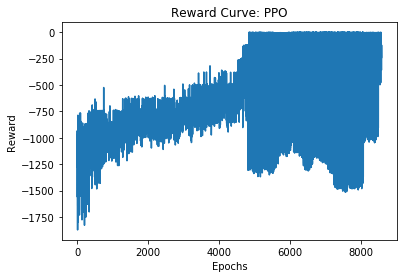

In [38]:
# plot the reward curve
fig = plt.figure()
plt.plot(scores)
plt.xlabel('Epochs')
plt.ylabel('Reward')
plt.title('Reward Curve: PPO')
plt.show()

### 6. Watch the smart agent

In [ ]:
# uncomment this cell to load the trained policy for Pendulum-v0
# load policy
policy =  torch.load('ppo-crawler.policy',map_location='cpu')
agent = Agent(env)
agent.policy = policy

In [ ]:
frames = []
total_rewards = np.zeros(12)

# reset the environment
states = np.array(env.reset())
value = []
r = []
for t in range(2000):
    prediction = agent.policy.act(states)
    action  = prediction['a'].cpu().numpy()
    v = prediction['v'].detach().cpu().numpy()
    #frames.append(env.render(mode='rgb_array')) 
    
    
    # send all actions to tne environment
    next_states,rewards,terminals,_ = env.step(list(action))

    next_states = np.array(next_states)
    rewards = np.array(rewards)                   
    terminals = np.array(terminals)
    
    #value.append(v.squeeze())
    #r.append(reward)
    states=next_states
    total_rewards+= rewards
    if np.any(terminals):
        for i,terminal in enumerate(terminals):
            if terminal:
                eps_reward = total_rewards[i]
                break
        break
        
print ("Total reward:",eps_reward)
#animate_frames(frames)

In [48]:
np.array(3).reshape(-1)

array([3])